In [1]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

### 1. 准备数据

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn

In [3]:
torch.manual_seed(0)

#样本数量
n = 400

# 生成测试用数据集
X = 10 * torch.rand([n, 2]) - 5.0  #rand均匀分布; X： 400*2 (-5, 5)均匀分布
w0 = torch.tensor([[2.0], [-3.0]]) # w0: 2*1
b0 = torch.tensor([[10.0]])

# 增加正态扰动
Y = X @ w0 + b0 + torch.normal(0.0, 2.0, size = [n, 1]) # 离散正态分布, mean = 0, std = 2
# X = [x1, x2] w0 = [2, 3]T Y = 2x1 - 3x2 + ... 
# x1: 400*1, x2:400*1, Y:400*1

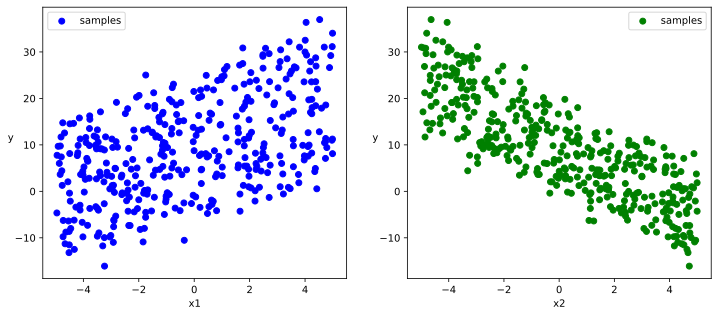

In [4]:
# 数据可视化
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 5))

# 绘制多个子图，1*2划分的第1个子图
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c = 'b', label = 'samples')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c = 'g', label = 'samples')
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y', rotation = 0)

plt.show()

### 2. 构建数据管道

In [5]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# 
ds = TensorDataset(X, Y)
dl = DataLoader(ds, shuffle=True, batch_size=10) # num_workers=4 报错

In [6]:
for features, labels in dl:
    print(features, labels)
    break

tensor([[-1.2024, -1.0515],
        [-2.3607,  4.5952],
        [ 1.9650,  4.1427],
        [ 4.3832, -3.3291],
        [ 0.9317, -3.8765],
        [-0.6871,  3.8822],
        [-1.0142,  2.7420],
        [ 2.0085, -3.0843],
        [ 2.6196, -2.3130],
        [-2.9401, -2.5380]]) tensor([[ 8.0042],
        [-7.3460],
        [ 0.9848],
        [28.7329],
        [19.1078],
        [-3.6075],
        [-1.6776],
        [23.5796],
        [20.7354],
        [ 9.4450]])


### 3.定义模型

In [7]:
model = nn.Linear(2, 1)
model.loss_func = nn.MSELoss() # Mean Suqared Error
model.optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [8]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
weight 	 torch.Size([1, 2])
bias 	 torch.Size([1])


### 4. 训练模型

In [9]:
def train_step(model, features, labels):
    predictions = model(features)
    loss = model.loss_func(predictions, labels)
    loss.backward()
    model.optimizer.step()
    model.optimizer.zero_grad()
    return loss.item()

# 测试train_step
features, labels = next(iter(dl))
train_step(model, features, labels)

82.18148040771484

In [10]:
def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        for features, labels in dl:
            loss = train_step(model, features, labels)
            
        if epoch%50 == 0:
            printbar()
            w = model.state_dict()["weight"]
            b = model.state_dict()["bias"]
            print("epoch =", epoch, "loss = ", loss)
            print("w =", w)
            print("b =", b)

In [11]:
train_model(model, epochs = 200)


================================================================================2020-12-10 10:24:26
epoch = 50 loss =  3.6201210021972656
w = tensor([[ 1.8719, -2.9800]])
b = tensor([9.8552])

================================================================================2020-12-10 10:24:26
epoch = 100 loss =  4.161522388458252
w = tensor([[ 2.0026, -3.0497]])
b = tensor([9.8246])

================================================================================2020-12-10 10:24:27
epoch = 150 loss =  2.9550604820251465
w = tensor([[ 1.9488, -3.0625]])
b = tensor([9.8686])

================================================================================2020-12-10 10:24:28
epoch = 200 loss =  6.495266914367676
w = tensor([[ 1.9108, -3.0786]])
b = tensor([9.8288])


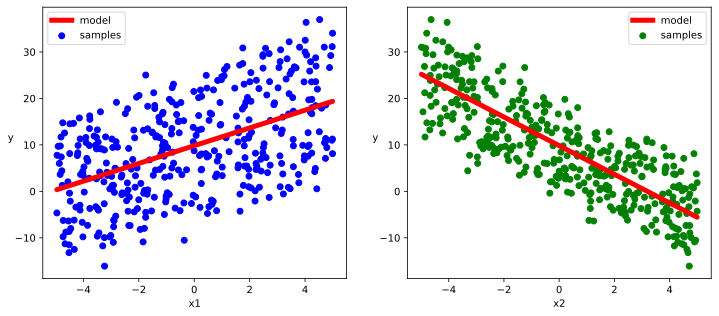

In [12]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 5))

w, b = model.state_dict()["weight"], model.state_dict()["bias"]

ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c = "b", label = "samples")
ax1.plot(X[:,0], w[0, 0]*X[:, 0]+b[0], "-r", linewidth = 5.0, label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c = "g", label = "samples")
ax2.plot(X[:, 1], w[0, 1]*X[:, 1]+b[0], "-r", linewidth = 5.0, label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation = 0)

plt.show()